The project we'll be doing in here is **Bear Detector**. It will discriminate between three types of bear: *grizzly, black, and teddy bears*. There are many images on the internet of each type of bear that we can use. We just need a way to find them and download them. We will be using the **jmd_imagescraper** library (https://github.com/joedockrill/jmd_imagescraper/) to gather the image datasets.

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
!pip install jmd_imagescraper

In [50]:
from fastbook import *
from fastai.vision.widgets import *
from jmd_imagescraper.core import duckduckgo_search 

In [66]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [31]:
if not path.exists():
    path.mkdir()
    
for o in bear_types:
    duckduckgo_search(path, o, f'{o} bear', max_results=150)

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Duckduckgo search: teddy bear


In [52]:
fns = get_image_files(path)
fns

(#445) [Path('bears/grizzly/060_0a143efb.jpg'),Path('bears/grizzly/110_4a296f95.jpg'),Path('bears/grizzly/103_0f789658.jpg'),Path('bears/grizzly/040_7f636624.jpg'),Path('bears/grizzly/082_e0d2a753.jpg'),Path('bears/grizzly/068_a3d21081.jpg'),Path('bears/grizzly/008_1809feff.jpg'),Path('bears/grizzly/035_b7963a86.jpg'),Path('bears/grizzly/144_91367958.jpg'),Path('bears/grizzly/003_c4ff9cab.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#0) []

If the above list is not empty, i.e., there are items in the data which are not images, following command helps to purge those items.

In [ ]:
failed.map(Path.unlink);

Having downloaded the relevant dataset, we now need a framework that can structure our data and split it into training and validation sets. This function is done by the `DataLoaders` object in fastai.

Following information is needed to be fed to convert the dataset into a `DataLoader` object

- the kind of data we are working with (image, sound, tabular, etc.)
- How to get the list of items/files
- How to label these items
- How to create the validation set

Fastai creates `DataLoaders` objects using `DataBlock` API, which is a robust system allowing us to fully customize every stage of the creation of our DataLoaders.

In [53]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

- `blocks=(ImageBlock, CategoryBlock)`

The independent variable is the thing we are using to make predictions from, and the dependent variable is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image.

- `get_items=get_image_files`

For DataLoaders our underlying items will be file paths. We have to tell fastai how to get a list of those files. The get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default)

- `splitter=RandomSplitter(valid_pct=0.2, seed=42)`

Here we simply split our training and validation sets randomly. `valid_pct` sets the percentage of data to keep as validation set. `seed` is the randomness seed.

- `get_y=parent_label`

Here, we tell fastai what function to call to create the labels in our dataset. `parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

- `item_tfms=Resize(128)`

This resizes all images to the same size, which is needed for deep learning, since they will be grouped in a big array which will be passed to the model.

We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [67]:
dls = bears.dataloaders(path)

A DataLoaders includes validation and training DataLoaders. DataLoader is a class that provides batches of a few items at a time to the GPU. We can take a look at a few of those items by calling the `show_batch` method on a DataLoader:

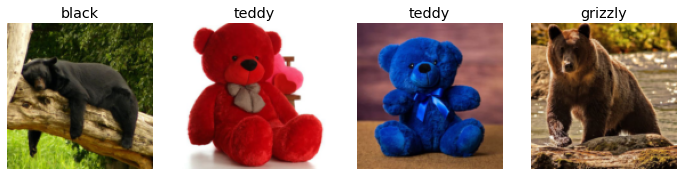

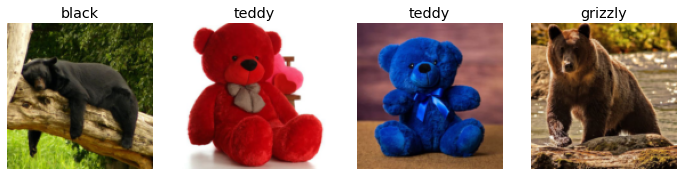

In [69]:
dls.valid.show_batch(max_n=4, nrows=1)

### Data augmentation

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter.

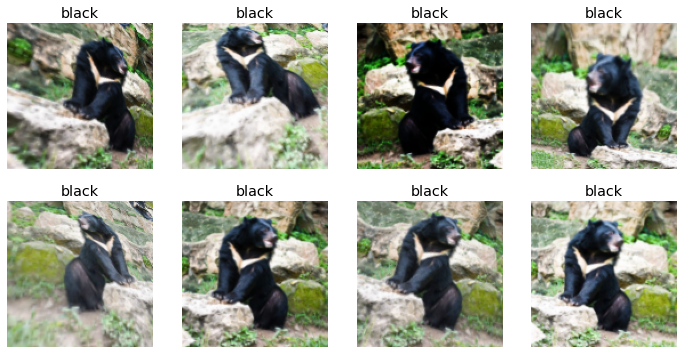

In [70]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training the model and using it to clean the data

We can now create our Learner and fine-tune it in the usual way:

In [72]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies, or that grizzlies are black bears, or something else. To visualize this, we can create a confusion matrix:

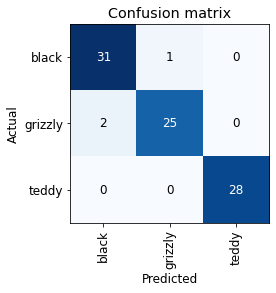

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

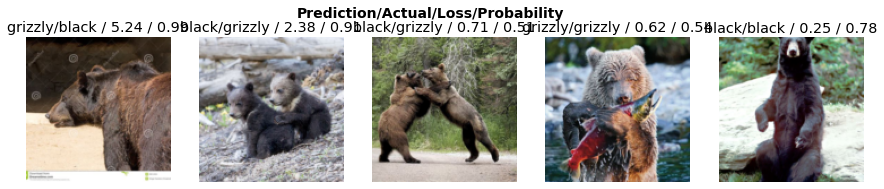

In [74]:
interp.plot_top_losses(5, nrows=1)

In [75]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [62]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## **Production**

In [76]:
learn.export()

In [77]:
path_ = Path()
path_.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [79]:
learn_inf = load_learner(path_/'export.pkl')

In [80]:
learn_inf.predict('bears/black/011_494b2d92.jpg')

('black', tensor(0), tensor([9.9999e-01, 4.8556e-06, 8.9007e-06]))

In [81]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']